## About

> RoBERTA

- It is also known as Robustly Optimized BERT Approach.
- It is a language model based on the BERT(Bidirectional Encoder Representations from Transformers) architecture.
- The core components of a block diagram of RoBERTA consists of Input Text, Tokenizer, Embedding Layer, multiple transformer encoders, pooling layer and the output.
- Input text is basically the raw text that needs to processed and can be a sentence, paragraph or an entire document.
- Tokenizer is the block where the input text is being fed and it splits it into individual tokens. The tokens can be words, subwords or even chars. Tokenization as a process helps in breaking down the text into meaningful units for further processing.
- Embeddings layer is the block which converts the tokenized text into word embeddings. Embeddings are vector representations of words or tokens which aim at capturing the semantic and contextual information. These embeddings are learned during the training proces and are used to represent the input tokens.
- Transformer Encoder is being utilized by ROBERTA over a stack. Each transformer encoder consists of multiple attention layers and feed forward neural networks. These encoders process the embedding in a self attention mechanism where each token attends to other tokens in the input sequence thereby capturing the dependencies and relationships between them. These stacked transformer encoders capture hierarhical information in the input text.
- The output of the transformer encoder's last layer is being passed through the pooling layer. The pooling layer aggregates the information from all the tokens into a fixed length representation such as mean or max of them. This pooled representation captures the semantic meaning of the input text.
- Finally, The pooled representation is passed through a linear layer or other classif/regression layers to produce the desired output.

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "suraj520"
os.environ["KAGGLE_KEY"] = "3f7b336dcca01a32b5c1c511af889e78"

In [ ]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews


  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 171MB/s]


In [ ]:
!unzip sentiment-analysis-on-movie-reviews.zip

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

In [ ]:
train_df = pd.read_csv("train.tsv.zip", sep="\t")
test_df = pd.read_csv("test.tsv.zip", sep="\t")

# Split into input text and corresponding labels
train_text = train_df["Phrase"].tolist()
train_labels = train_df["Sentiment"].tolist()
test_text = test_df["Phrase"].tolist()


In [ ]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [ ]:
# Tokenize the input text
train_tokens = tokenizer.batch_encode_plus(
    train_text,
    padding=True,
    truncation=True,
    return_tensors="pt"
)


In [ ]:
# Prepare the input dataset
class MovieReviewsDataset(Dataset):
    def __init__(self, tokens, labels):
        self.input_ids = tokens["input_ids"]
        self.attention_mask = tokens["attention_mask"]
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return {
            "input_ids": self.input_ids[index],
            "attention_mask": self.attention_mask[index],
            "labels": self.labels[index]
        }


In [ ]:
train_dataset = MovieReviewsDataset(train_tokens, train_labels)

In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5)
model.to(device)

# Prepare the dataloader
batch_size = 32*4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
# Initialize the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
# Training loop
from tqdm import tqdm
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        if step%100==0:
          print("Step-{}, Loss-{}".format(step,loss.item()))
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

0it [00:00, ?it/s]

Step-0, Loss-1.5351877212524414


100it [02:26,  1.46s/it]

Step-100, Loss-0.9756748080253601


200it [04:51,  1.46s/it]

Step-200, Loss-0.8548558950424194


300it [07:17,  1.45s/it]

Step-300, Loss-0.6825312972068787


400it [09:43,  1.45s/it]

Step-400, Loss-0.8613194823265076


500it [12:08,  1.45s/it]

Step-500, Loss-0.630751371383667


600it [14:34,  1.45s/it]

Step-600, Loss-0.7979530096054077


700it [16:59,  1.45s/it]

Step-700, Loss-0.7271313667297363


800it [19:25,  1.45s/it]

Step-800, Loss-0.6418065428733826


900it [21:51,  1.46s/it]

Step-900, Loss-0.8061614036560059


1000it [24:16,  1.45s/it]

Step-1000, Loss-0.7546658515930176


1100it [26:41,  1.45s/it]

Step-1100, Loss-0.881874144077301


1200it [29:07,  1.46s/it]

Step-1200, Loss-0.8997511863708496


1220it [29:35,  1.46s/it]


Epoch 1/5, Average Loss: 0.8083


0it [00:00, ?it/s]

Step-0, Loss-0.7351599335670471


100it [02:25,  1.46s/it]

Step-100, Loss-0.735181450843811


200it [04:51,  1.45s/it]

Step-200, Loss-0.7025976777076721


300it [07:16,  1.46s/it]

Step-300, Loss-0.7172818779945374


400it [09:42,  1.46s/it]

Step-400, Loss-0.7566203474998474


500it [12:07,  1.45s/it]

Step-500, Loss-0.6831374168395996


600it [14:33,  1.46s/it]

Step-600, Loss-0.6197997331619263


700it [16:58,  1.45s/it]

Step-700, Loss-0.6673067808151245


800it [19:24,  1.45s/it]

Step-800, Loss-0.5941049456596375


900it [21:49,  1.45s/it]

Step-900, Loss-0.733845591545105


1000it [24:15,  1.46s/it]

Step-1000, Loss-0.6613959074020386


1100it [26:40,  1.46s/it]

Step-1100, Loss-0.7154840230941772


1200it [29:06,  1.45s/it]

Step-1200, Loss-0.7117800116539001


1220it [29:34,  1.45s/it]


Epoch 2/5, Average Loss: 0.6983


0it [00:00, ?it/s]

Step-0, Loss-0.5501241087913513


100it [02:25,  1.45s/it]

Step-100, Loss-0.6431103944778442


200it [04:51,  1.46s/it]

Step-200, Loss-0.6930710077285767


300it [07:16,  1.45s/it]

Step-300, Loss-0.6709518432617188


400it [09:42,  1.46s/it]

Step-400, Loss-0.6845566034317017


500it [12:07,  1.45s/it]

Step-500, Loss-0.7604778409004211


600it [14:33,  1.45s/it]

Step-600, Loss-0.5870668292045593


700it [16:58,  1.45s/it]

Step-700, Loss-0.6723702549934387


800it [19:23,  1.45s/it]

Step-800, Loss-0.6351805329322815


900it [21:49,  1.46s/it]

Step-900, Loss-0.6650876998901367


1000it [24:14,  1.45s/it]

Step-1000, Loss-0.6299334168434143


1100it [26:40,  1.45s/it]

Step-1100, Loss-0.6397178769111633


1200it [29:05,  1.45s/it]

Step-1200, Loss-0.5819687247276306


1220it [29:33,  1.45s/it]


Epoch 3/5, Average Loss: 0.6491


0it [00:00, ?it/s]

Step-0, Loss-0.5726202130317688


100it [02:25,  1.45s/it]

Step-100, Loss-0.6116303205490112


200it [04:50,  1.45s/it]

Step-200, Loss-0.5551882386207581


300it [07:16,  1.45s/it]

Step-300, Loss-0.6866909265518188


400it [09:41,  1.45s/it]

Step-400, Loss-0.5046600699424744


500it [12:06,  1.45s/it]

Step-500, Loss-0.6812744736671448


600it [14:32,  1.45s/it]

Step-600, Loss-0.5305469632148743


700it [16:57,  1.45s/it]

Step-700, Loss-0.5688374042510986


800it [19:23,  1.46s/it]

Step-800, Loss-0.41824278235435486


900it [21:49,  1.46s/it]

Step-900, Loss-0.48342445492744446


1000it [24:14,  1.46s/it]

Step-1000, Loss-0.6759509444236755


1100it [26:40,  1.45s/it]

Step-1100, Loss-0.7022517323493958


1200it [29:05,  1.45s/it]

Step-1200, Loss-0.6426094770431519


1220it [29:33,  1.45s/it]


Epoch 4/5, Average Loss: 0.6121


0it [00:00, ?it/s]

Step-0, Loss-0.523365318775177


100it [02:25,  1.45s/it]

Step-100, Loss-0.4929826557636261


200it [04:50,  1.45s/it]

Step-200, Loss-0.5775153636932373


300it [07:15,  1.45s/it]

Step-300, Loss-0.5991526246070862


400it [09:40,  1.45s/it]

Step-400, Loss-0.6172200441360474


500it [12:05,  1.45s/it]

Step-500, Loss-0.5966829061508179


600it [14:30,  1.45s/it]

Step-600, Loss-0.4454188644886017


700it [16:55,  1.45s/it]

Step-700, Loss-0.5131547451019287


800it [19:20,  1.44s/it]

Step-800, Loss-0.6010434031486511


900it [21:45,  1.45s/it]

Step-900, Loss-0.569153904914856


1000it [24:10,  1.46s/it]

Step-1000, Loss-0.5800294280052185


1100it [26:36,  1.46s/it]

Step-1100, Loss-0.5638339519500732


1200it [29:01,  1.45s/it]

Step-1200, Loss-0.6426364183425903


1220it [29:29,  1.45s/it]

Epoch 5/5, Average Loss: 0.5784


In [10]:
# Tokenize the test text
test_tokens = tokenizer.batch_encode_plus(
    test_text,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

In [11]:
# Prepare the test dataset
test_dataset = MovieReviewsDataset(test_tokens, [0]*len(test_text))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [13]:
# Evaluation loop
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_labels.cpu().numpy().tolist())


100%|██████████| 518/518 [03:57<00:00,  2.18it/s]


In [17]:
# Prepare the submission file
submission_df = pd.DataFrame({"PhraseId": test_df["PhraseId"], "Sentiment": predictions})


In [15]:
# Convert sentiment labels to the required format
sentiment_labels = ["negative", "somewhat negative", "neutral", "somewhat positive", "positive"]
submission_df["Sentiment"] = submission_df["Sentiment"].apply(lambda x: sentiment_labels[x])


In [18]:
submission_df

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,1
66288,222349,1
66289,222350,1
66290,222351,1


In [19]:
# Save the submission file
submission_df.to_csv("submission.csv", index=False)

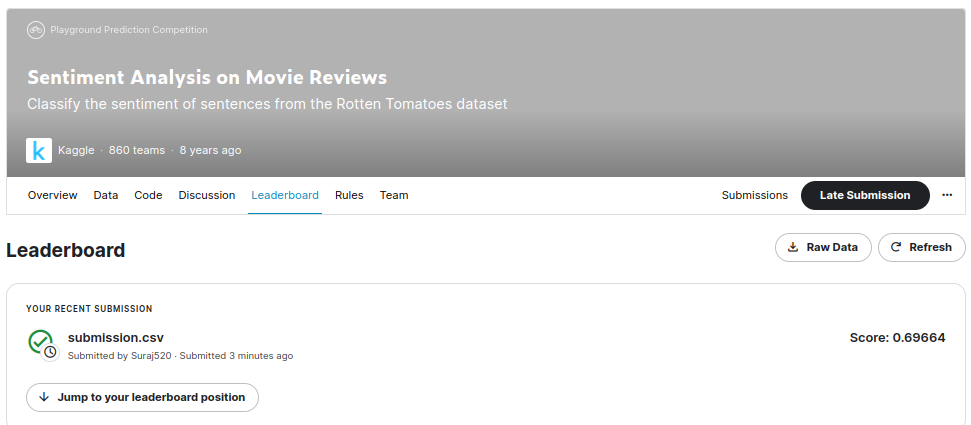